## 유전알고리즘(Genetic Algorithm)을 활용한 Feature Selection 예제 코드

- Data: 이진 분류
- 370개의 피처로 이루어진 데이터 세트 기반에서 고객만족 여부를 예측하는 것
- 피처이름은 모두 익명화되어 있어 어떤 속성인지는 알 수 없음

In [1]:
import os
import random

import numpy as np
import pandas as pd
import datetime

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from model.feature_select import fnFeatSelect_RandVar
from model.feature_select import fnFeatSelect_GeneticAlgo

from model.optimize_hyperparameter import fnOpt_HyperPara

from utils.visualize import fnPrecision_Recall_Curve_Plot

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from hyperopt import fmin, hp, STATUS_OK, Trials, tpe

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 50)
pd.set_option('display.max_column', None)

## Load Data

In [2]:
trainData = pd.read_csv('data/train.csv')
testData = pd.read_csv('data/test.csv')

print('===== Train Data: {} ====='.format(trainData.shape))
print(trainData.head(5))
print('===== Test Data: {} ====='.format(testData.shape))
print(testData.head(5))


===== Train Data: (76020, 371) =====
   ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  \
0    

In [3]:
## Y변수
TARGET_NM = 'TARGET'
## X변수 리스트
featureList = list(set(trainData.columns) - set(['ID', TARGET_NM]))
## Sedd
SEED_NUM = 1000

# Train / Valid(8:2) 분할

In [4]:
(
    trainX, 
    validX, 
    trainY, 
    validY
) = train_test_split(
    trainData[featureList], 
    trainData[TARGET_NM], 
    test_size = 0.2, 
    random_state = 1000,
    stratify = trainData[TARGET_NM],
    shuffle = True
)

print('Train Data: {}'.format(trainX.shape))
print('Valid Data: {}'.format(validX.shape), '\n')

print('Target Value(TrainX) Count')
print(trainY.value_counts())


Train Data: (60816, 369)
Valid Data: (15204, 369) 

Target Value(TrainX) Count
TARGET
0    58410
1     2406
Name: count, dtype: int64


# 전처리 - Scale
- 변수 간 Scale을 0~1사이로 통일

In [5]:
## 변수 Scale
scaler = MinMaxScaler()
trainScale = scaler.fit_transform(trainX[featureList])
validScale = scaler.transform(validX[featureList])

## DataFrame 변환
trainScale_DF = pd.DataFrame(
    trainScale,
    columns = featureList
)
trainScale_DF[TARGET_NM] = trainY.values
validScale_DF = pd.DataFrame(
    validScale,
    columns = featureList
)
validScale_DF[TARGET_NM] = validY.values

print('Scaled Train Info')
print(trainScale_DF.describe(), '\n')
print('Scaled Test Info')
print(validScale_DF.describe(), '\n')


Scaled Train Info
       ind_var27_0  num_reemb_var17_hace3  saldo_medio_var12_hace2  \
count      60816.0                60816.0             60816.000000   
mean           0.0                    0.0                 0.001300   
std            0.0                    0.0                 0.012059   
min            0.0                    0.0                 0.000000   
25%            0.0                    0.0                 0.000000   
50%            0.0                    0.0                 0.000000   
75%            0.0                    0.0                 0.000000   
max            0.0                    0.0                 1.000000   

          ind_var17  num_var28_0  ind_var46  imp_op_var39_efect_ult1  \
count  60816.000000      60816.0    60816.0             60816.000000   
mean       0.001562          0.0        0.0                 0.001506   
std        0.039493          0.0        0.0                 0.012342   
min        0.000000          0.0        0.0                 0.0

# Data 불균형 
- SMOTE알고리즘으로 데이터 불균형 처리

In [7]:
## SMOTE 선언
Smote = SMOTE(random_state = SEED_NUM)
## Resampling
trainResample_X, trainResample_Y = Smote.fit_resample(
    trainScale_DF[featureList],
    trainScale_DF[TARGET_NM]
)
trainResample_DF = trainResample_X.copy()
trainResample_DF[TARGET_NM] = trainResample_Y.values

print('After OverSampling, the shape of TrainData: {} \n'.format(trainResample_X.shape))
print("After OverSampling, counts of label '1': {}".format(sum(trainResample_Y == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(trainResample_Y == 0)), '\n')

print('Resample Data')
display(trainResample_DF)

After OverSampling, the shape of TrainData: (116820, 369) 

After OverSampling, counts of label '1': 58410
After OverSampling, counts of label '0': 58410 

Resample Data


,ind_var27_0,num_reemb_var17_hace3,saldo_medio_var12_hace2,ind_var17,num_var28_0,ind_var46,imp_op_var39_efect_ult1,num_var20,saldo_var37,delta_imp_trasp_var17_out_1y3,num_op_var40_ult1,ind_var18_0,num_var30_0,num_venta_var44_hace3,num_var13_0,num_var44_0,saldo_medio_var8_hace2,ind_var13_0,delta_imp_compra_var44_1y3,imp_aport_var33_hace3,saldo_medio_var17_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,ind_var13_largo,var3,num_var44,ind_var8_0,saldo_var34,imp_reemb_var13_ult1,saldo_medio_var13_corto_ult1,num_aport_var13_hace3,ind_var9_ult1,num_var5,num_var43_recib_ult1,num_var1_0,num_op_var41_comer_ult3,num_var42_0,num_aport_var17_ult1,delta_imp_aport_var33_1y3,delta_num_reemb_var33_1y3,ind_var37_cte,imp_op_var41_ult1,imp_ent_var16_ult1,imp_op_var41_comer_ult3,delta_num_venta_var44_1y3,imp_compra_var44_hace3,num_var17,num_var29,num_var45_hace2,ind_var32_0,saldo_var18,num_var31_0,num_trasp_var33_in_ult1,ind_var2_0,saldo_medio_var13_largo_hace3,var21,ind_var14,num_var8_0,delta_imp_aport_var13_1y3,ind_var17_0,saldo_var1,ind_var41,ind_var44,num_var34,var36,ind_var33,num_var37_med_ult2,imp_op_var40_efect_ult1,num_var41_0,delta_num_trasp_var33_out_1y3,delta_num_trasp_var17_out_1y3,num_var25_0,saldo_var31,num_trasp_var33_in_hace3,delta_imp_reemb_var33_1y3,imp_sal_var16_ult1,num_var20_0,num_var37,num_op_var40_hace2,ind_var32_cte,num_venta_var44_ult1,num_aport_var17_hace3,ind_var5,saldo_medio_var13_medio_ult3,num_op_var41_hace2,ind_var28,num_var13_largo,saldo_var17,ind_var43_emit_ult1,saldo_var13_largo,ind_var31,num_var2_ult1,ind_var25,imp_trasp_var33_in_ult1,num_var14,saldo_medio_var33_ult3,num_var46_0,saldo_medio_var13_largo_ult3,saldo_medio_var29_ult1,num_var31,num_reemb_var33_hace3,delta_num_trasp_var33_in_1y3,delta_imp_amort_var34_1y3,num_var46,saldo_var6,num_op_var39_hace3,num_op_var39_efect_ult3,imp_aport_var17_ult1,num_var30,num_var6,saldo_medio_var13_corto_hace2,ind_var10_ult1,saldo_var13_corto,num_meses_var29_ult3,num_var13_medio,ind_var26,num_op_var39_efect_ult1,num_meses_var13_medio_ult3,imp_compra_var44_ult1,ind_var41_0,num_op_var39_comer_ult3,num_var34_0,saldo_var20,delta_num_compra_var44_1y3,num_meses_var17_ult3,imp_trasp_var17_out_ult1,saldo_medio_var44_ult3,num_meses_var39_vig_ult3,imp_trans_var37_ult1,saldo_medio_var8_hace3,delta_num_reemb_var17_1y3,ind_var37_0,saldo_var27,imp_var7_recib_ult1,ind_var25_0,ind_var2,saldo_medio_var12_ult3,saldo_medio_var29_hace2,num_var27_0,num_var26_0,ind_var13_medio_0,ind_var25_cte,num_var8,ind_var13_corto_0,imp_amort_var18_ult1,ind_var12_0,num_var13_corto_0,delta_imp_aport_var17_1y3,ind_var32,ind_var12,num_meses_var13_corto_ult3,num_var42,num_meses_var33_ult3,imp_aport_var17_hace3,ind_var14_0,delta_num_trasp_var17_in_1y3,num_var22_hace3,ind_var39_0,num_var39_0,saldo_var5,imp_aport_var33_ult1,imp_venta_var44_hace3,ind_var24,saldo_var28,delta_imp_trasp_var17_in_1y3,imp_reemb_var33_ult1,imp_trasp_var33_in_hace3,num_sal_var16_ult1,ind_var9_cte_ult1,ind_var29,num_op_var39_comer_ult1,num_op_var39_ult3,ind_var20,num_var32,ind_var5_0,imp_aport_var13_ult1,num_var22_ult1,num_compra_var44_hace3,imp_op_var40_comer_ult1,saldo_medio_var13_largo_hace2,saldo_var40,saldo_var2_ult1,saldo_medio_var13_corto_hace3,imp_reemb_var13_hace3,num_var41,imp_reemb_var17_hace3,imp_venta_var44_ult1,num_op_var39_hace2,num_var7_recib_ult1,ind_var31_0,num_op_var40_comer_ult1,ind_var13_medio,imp_trasp_var17_in_ult1,num_meses_var8_ult3,delta_imp_reemb_var13_1y3,ind_var30,num_var28,num_var26,num_var14_0,ind_var40,num_var13,num_aport_var33_ult1,saldo_medio_var33_ult1,num_var29_0,num_var25,ind_var39,saldo_medio_var17_ult1,saldo_var42,saldo_medio_var8_ult3,num_compra_var44_ult1,num_op_var41_comer_ult1,saldo_medio_var5_ult3,num_var39,delta_num_aport_var13_1y3,delta_num_aport_var33_1y3,ind_var6_0,imp_trasp_var33_out_hace3,num_trasp_var11_ult1,ind_var43_recib_ult1,saldo_medio_var12_hace3,ind_var34_0,ind_var44_0,saldo_var33,num_var45_ult3,num_reemb_var17_ult1,saldo_medio_var12_ult1,imp_trasp_var17_out_hace3,num_var13_medio_0

# 변수선택1 - Random Feature
- 난수로 생성한 임의변수들보다 변수중요도가 낮은 변수들을 제거하는 알고리즘
- Boruta 알고리즘과 유사함
- Boruta과 차이점은, Boruta은 기존 변수 각각을 임의로 섞은 변수를 생성한 후 변수중요도를 구하는 것이고
- 해당 로직은 임의의 난수로 생성한 랜덤 변수를 여러 개 생성한 후 변수중요도를 계산하는 것

In [8]:
%%time

## 임의로 생성한 Random변수들보다 변수중요도가 떨어지는 변수들을 제거하는 로직
feat_RandSelct_LS = fnFeatSelect_RandVar(
    df_x = trainResample_DF[featureList], 
    df_y = trainResample_DF[TARGET_NM], 
    x_var = featureList, 
    core_cnt = -1,
    rand_num = 50, 
    threshold = 0.000,
    n_estimators = 3000,
    seed = SEED_NUM
)
deleteFeatureLS = list(set(featureList) - set(feat_RandSelct_LS))
print('Feauter List with Rand-Select({}): {}'.format(len(feat_RandSelct_LS), feat_RandSelct_LS))

if len(deleteFeatureLS) > 0:
    print('Delete Feature List({}): {}'.format(len(deleteFeatureLS), deleteFeatureLS))


Feauter List with Rand-Select(27): ['ind_var30', 'ind_var5', 'num_med_var22_ult3', 'num_med_var45_ult3', 'num_meses_var5_ult3', 'num_var22_hace2', 'num_var22_hace3', 'num_var22_ult1', 'num_var22_ult3', 'num_var30', 'num_var35', 'num_var4', 'num_var42', 'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1', 'num_var45_ult3', 'num_var5', 'saldo_medio_var5_hace2', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'saldo_var30', 'saldo_var42', 'saldo_var5', 'var15', 'var36', 'var38']
Delete Feature List(342): ['ind_var27_0', 'num_reemb_var17_hace3', 'saldo_medio_var12_hace2', 'ind_var17', 'num_var28_0', 'ind_var46', 'imp_op_var39_efect_ult1', 'num_var20', 'saldo_var37', 'delta_imp_trasp_var17_out_1y3', 'num_op_var40_ult1', 'ind_var18_0', 'num_var30_0', 'num_venta_var44_hace3', 'num_var13_0', 'num_var44_0', 'saldo_medio_var8_hace2', 'ind_var13_0', 'delta_imp_compra_var44_1y3', 'imp_aport_var33_hace3', 'saldo_medio_var17_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'ind_var1

# 변수선택2 - 유전 알고리즘
- 최적화 알고리즘 하나인 유전 알고리즘을 활용하여 변수선택을 수행

In [9]:
%%time

## 모델 선언
model_instance = RandomForestClassifier(random_state = SEED_NUM, n_jobs = -1, n_estimators = 300)
## 변수 선택(유전 알고리즘)
(
    feat_Genetic_LS, 
    geneticScoreList, 
    geneticFeatList_PerGeneration
) = fnFeatSelect_GeneticAlgo(
    n = 30,
    feat_num = len(feat_RandSelct_LS),
    select_sol_num = 10,
    p = 0.2,
    q = 0.2,
    num_generation = 300,
    x_df = trainResample_DF[feat_RandSelct_LS],
    y = trainResample_DF[TARGET_NM],
    model_instance = model_instance,
    cv_num = 2,
    scoring = 'neg_log_loss',
    seed = SEED_NUM
)
deleteGeneticFeatureLS = list(set(feat_RandSelct_LS) - set(feat_Genetic_LS))
print('Feauter List with Genetic Algorithm({}): {}'.format(len(feat_Genetic_LS), feat_Genetic_LS))

if len(deleteFeatureLS) > 0:
    print('Delete Feature List({}): {}'.format(len(deleteGeneticFeatureLS), deleteGeneticFeatureLS))

Genetic Algorithm for Feature Selection is Start


Genetic Algorithm for Feature Selection:   0%|          | 0/300 [00:00<?, ?it/s]

Genetic Algorithm Score: "-0.2720027258581732":   1%|          | 2/300 [11:53<32:13:26, 389.28s/it]

2/300: Feature Selection!(Count: 15)


Genetic Algorithm Score: "-0.2720027258581732":   1%|          | 4/300 [32:29<45:07:29, 548.82s/it]

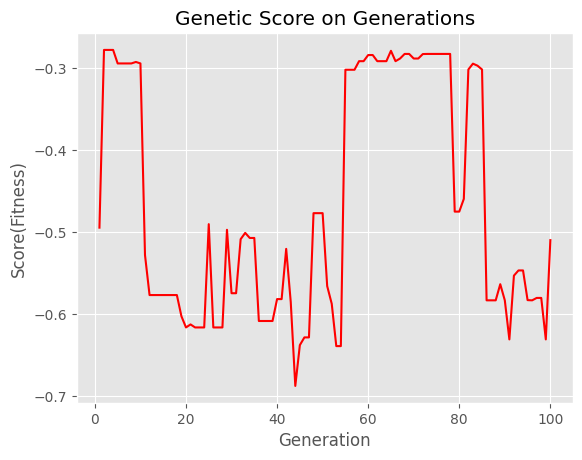

In [ ]:
plt.style.use('ggplot')

plt.figure()
plt.plot(
    np.arange(1, len(geneticScoreList) + 1),
    geneticScoreList,
    color = 'red'
)
plt.xlabel('Generation')
plt.ylabel('Score(Fitness)')
plt.title('Genetic Score on Generations')

plt.show()

# Hyper-parameter 최적화
- Bayesian Optimizing w/ TPE 활용

In [ ]:
## 최종 변수List
feat_Final_LS = feat_RandSelct_LS

## Model 선택
MODEL_NM = 'xgb'
## Hyper-parameter 탐색공간
H_PARA_SPACE = {
    'rf': {
        'max_depth': hp.uniform("max_depth", 2, 100),
        'min_samples_leaf': hp.uniform("min_samples_leaf", 2, 30),
        'min_samples_split': hp.uniform("min_samples_split", 2, 30),
        'max_features': hp.uniform("max_features", 2, int(len(feat_Final_LS) * 0.8))
    },
    'xgb': {
        'max_depth': hp.uniform("max_depth", 2, 100),
        'min_child_weight': hp.loguniform('min_child_weight', -3, 3),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'gamma': hp.loguniform('gamma', -10, 10)
    },
    'lgbm': {
        'max_depth': hp.uniform("max_depth", 2, 100),
        'min_child_weight': hp.loguniform('min_child_weight', -3, 3),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'num_leaves': hp.uniform('num_leaves', 5, 30)
    }
}
## Bayesian Optimizing with TPE
TrialResult, BestPara = fnOpt_HyperPara(
    total_data = trainScale_DF, 
    x_var = feat_Final_LS, 
    y_var = TARGET_NM, 
    space = H_PARA_SPACE[MODEL_NM], 
    lean_rate_ls = [0.001, 0.01, 0.1], 
    ml_model = MODEL_NM, 
    core_cnt = -1, 
    cv_num = 3, 
    max_evals = 50, 
    seed = 1000, 
    verbose = True,
)

# 최종 모델 학습

In [ ]:
if MODEL_NM == 'rf':
    finalModel = RandomForestClassifier(**BestPara)
    finalModel.fit(
        trainScale_DF[feat_Final_LS], 
        trainScale_DF[TARGET_NM]
    )
elif MODEL_NM == 'xgb':
    finalModel = XGBClassifier(**BestPara)
    finalModel.fit(
        X = trainScale_DF[feat_Final_LS], 
        y = trainScale_DF[TARGET_NM],
        early_stopping_rounds = 50,
        eval_set = [(trainScale_DF[feat_Final_LS], trainScale_DF[TARGET_NM])],
        verbose = False
    )
else:
    finalModel = LGBMClassifier(**BestPara)
    finalModel.fit(
        X = trainScale_DF[feat_Final_LS], 
        y = trainScale_DF[TARGET_NM],
        eval_set = [(trainScale_DF[feat_Final_LS], trainScale_DF[TARGET_NM])],
        callbacks = [
            early_stopping(
                stopping_rounds = 30,
                verbose = False
                )
            ]
    )

## Cut-off 지점
- Precision, Recall 둘 사이의 최적값 선택

In [ ]:
## Cut-off 지점
## Precission, Recall 사이에서의 최적지점
OPT_CUT_OFF = fnPrecision_Recall_Curve_Plot(
    y_test = validScale_DF[TARGET_NM],
    pred_proba = finalModel.predict_proba(validScale_DF[feat_Final_LS])[:, 1],
    plot_flag = True
)